# Results

Testing networks and saving results

TODO:
- clean up repeated bits into functions
- save csv files with results to share/use elsewhere

In [1]:
# imports
import os
import yaml
from functools import reduce
import numpy as np
import pandas as pd
import theano
import lasagne
import loading
from training import *
from network import *
from architectures import *
from scipy.stats import bayes_mvs, entropy, linregress, spearmanr

# aliases
L = lasagne.layers
nl = lasagne.nonlinearities
T = theano.tensor
bmvs = bayes_mvs

## Data Loading

In [2]:
headdir = os.path.expanduser('~/Google Drive/Bas Zahy Gianni - Games')
paramsdir = os.path.join(headdir, 'Analysis/0_hvh/Params/nnets/temp')
datadir = os.path.join(headdir, 'Data/model input')
resultsdir = os.path.join(headdir, 'Analysis/0_hvh/Loglik/nnets')

data = loading.default_loader(os.path.join(datadir, '1-4 (no computer).csv'))
hvhdata = loading.default_loader(os.path.join(datadir, '0 (with groups).csv'))
df = hvhdata[0]
Xs = np.concatenate(hvhdata[2])
ys = np.concatenate(hvhdata[3])
Ss = np.concatenate(hvhdata[4])

defmod = np.loadtxt(os.path.expanduser('~/Downloads/loglik_hvh_final.txt')).reshape([40, 5])

## Compile Results

In [8]:
def unfreeze(net):
    for layer in L.get_all_layers(net.net):
        for param in layer.params:
            layer.params[param].add('trainable')
    net.params = L.get_all_params(net.net, trainable=True)
    
    return None

def load_arch_specs(archname):
    with open('arch_specs.yaml') as archfile:
        arch = yaml.load(archfile)
    return arch[archname]

def load_pretrain_results(archname, archfunc, idx, net=None):
    specs = load_arch_specs(archname)
    arch = lambda input_var: archfunc(input_var, **specs['kwargs'])
    fname = '{} {} split agg fit exp 1-4.npz'.format(archname, idx)
    resdf = pd.DataFrame(index=np.arange(Xt.shape[0]), columns=[idx])

    if net is None:
        net = Network(arch)
    
    net.load_params(os.path.join(paramsdir, fname))
    res = net.itemized_test_fn(Xt, yt)
    resdf[idx] = res
    return resdf, net

def load_train_results(archname, archfunc, idx, test_idx, net=None):
    specs = load_arch_specs(archname)
    arch = lambda input_var: archfunc(input_var, **specs['kwargs'])
    fname = '{} {} agg fit exp 1-4 {} tune fit exp 0.npz'.format(archname, idx, test_idx)
    resdf = pd.DataFrame(index=np.arange(Xt.shape[0]), columns=[idx])
    
    if net is None:
        net = Network(arch)
    
    net.load_params(os.path.join(paramsdir, fname))
    
    group_idx = (test_idx - 1) % 5
    selection = df.loc[df['group']==(group_idx+1)].index.values
    res = net.itemized_test_fn(Xt[selection, :, :, :], yt[selection])
    resdf.loc[selection, idx] = res
    return resdf, net

In [4]:
archname = 'multiconvX_ws_large'
archfunc = multiconvX_ws
Xt, yt, _, _, _ = loading.unpack_data(df)

pretrain_nets = []
pretrain_results = []
# net = Network()

for idx in range(5):
    resdf, net = load_pretrain_results(archname, archfunc, idx)
    pretrain_nets.append(net)
    pretrain_results.append(resdf)

pretrain_results = pd.concat(pretrain_results, axis=1)
pretrain_results.to_csv(os.path.join(resultsdir, 'pretrain {}.csv'.format(archname)))

In [5]:
train_nets = []
train_results = []
for idx in range(5):
    for test_idx in range(5):
        resdf, net = load_train_results(archname, archfunc, idx, test_idx)
        train_nets.append(net)
        train_results.append(resdf)

train_results = pd.concat(train_results, axis=1, join='inner').stack().unstack()
train_results.to_csv(os.path.join(resultsdir, 'train {}.csv'.format(archname)))

In [6]:
train_results['mean'] = train_results.mean(axis=1)
bmvs(train_results.pivot_table(index=df['subject'], values='mean').values)

(Mean(statistic=1.9569956299072935, minmax=(1.8652257692999743, 2.0487654905146124)),
 Variance(statistic=0.12507991692401582, minmax=(0.08480425147075453, 0.18010844957876854)),
 Std_dev(statistic=0.35128509800731866, minmax=(0.29121169528498425, 0.42439185852083511)))

# Count Params

In [9]:
def get_num_params(net):
    l = L.get_all_param_values(net)
    return np.array([p.size for p in l])

get_num_params(net.net).sum()

8849

# Response Times

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
plt.rc('text', usetex=True)

%matplotlib inline

In [202]:
scatterkws = {
    'linestyle': 'none', 
    'marker': 'o', 'markerfacecolor': (.2, .2, .2), 'markeredgecolor': 'black', 
    'alpha': .3
}

histkws = {
    'edgecolor': 'white'
}

In [111]:
def hicks_entropy(pred):
    H = pred * np.log2(1 / (pred + 1))
    return H.sum(axis=1)

In [ ]:
X, y, S, G, Np = loading.unpack_data(df)
df['mean corrected rt'] = 0
for subject in df['subject'].unique():
    fil = df['subject'] == subject
    df.loc[fil, 'mean corrected rt'] = df.loc[fil, 'rt'] - df.loc[fil, 'rt'].mean()

rt = df['mean corrected rt']

In [187]:
# compute mean entropy for each test group
E = []
for split_idx in range(25):
    N = train_nets[split_idx]
    locs = np.where(G==(split_idx//5))[0]
    L = N.output_fn(X[locs, :, :, :])
    E.append(hicks_entropy(L))

for g in range(5):
    df.loc[df['group']==(g+1), 'entropy'] = np.array(E[g*5:(g+1)*5]).T.mean(axis=1)

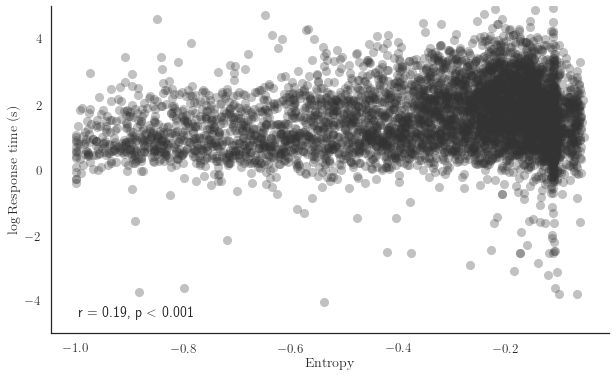

In [189]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

x = df['entropy']
y = np.log(df['rt']/1000)
axes.plot(x, y, **scatterkws)
lr = linregress(x, y)
pval = lr.pvalue if lr.pvalue >= .001 else .001
axes.text(.05, .05, r"r = {:.2f}, p $<$ {:.3f}".format(lr.rvalue, pval), transform=axes.transAxes, fontsize=14)
plt.setp(axes, xlabel=r"$\textrm{Entropy}$", ylabel=r'$\log{\textrm{Response time (s)}}$', ylim=[-5, 5])

sns.despine()

Hick's law holds (ish).

# Values

In [507]:
gendata = pd.read_csv(
    os.path.join(headdir, 'Data/1_gen/Clean/_summaries/all_evals_model_input.csv'),
    names=['subject', 'color', 'bp', 'wp', 'zet', 'rt', 'val']
)
gendata['group'] = -1

X, y, S, G, Np = loading.unpack_data(gendata)

In [687]:
N = train_nets[0]
logistic = lambda x: 1 / (1 + np.exp(-x))
zscore = lambda x: (x - x.mean()) / (x.std() / np.sqrt(x.shape[0]))
Vr = N.value_fn(X)
V = Vr.sum(axis=1)
Vl = 7*logistic(zscore(V))

V2 = np.zeros_like(V)
yz = np.zeros_like(y)
for subject in range(S.max()):
    V2[S==subject] = zscore(V[S==subject])
    yz[S==subject] = zscore(y[S==subject])
    
V2l = 7*logistic(V2)

In [688]:
Vr = N.value_fn(X) - N.value_fn(X[:, ::-1, :, :])

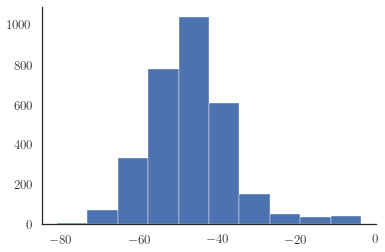

In [689]:
plt.hist(V, **histkws)
sns.despine()

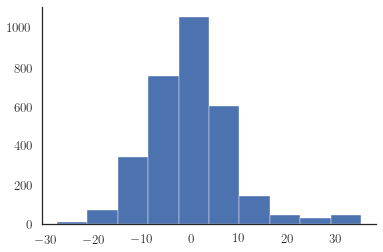

In [690]:
plt.hist(V2, **histkws) #, bins=np.arange(0, 8, .5), **histkws)
sns.despine()

LinregressResult(slope=-0.00059452868835669812, intercept=-0.16666666666666666, rvalue=-0.0061836856313960426, pvalue=0.72989382225533128, stderr=0.0017217855329001127)


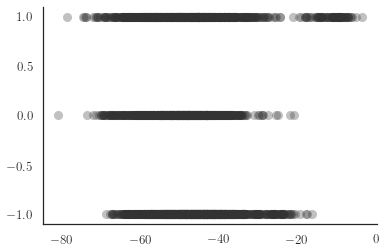

In [691]:
plt.plot(V, gendata['val'], **scatterkws)
print(linregress(V2, gendata['val']))
sns.despine()

LinregressResult(slope=-0.037260516825417402, intercept=-0.0025651404813908374, rvalue=-0.068824721565367813, pvalue=0.00011939660325125725, stderr=0.0096724238643908587)


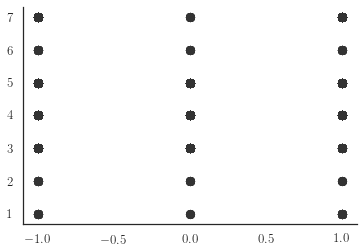

In [692]:
plt.plot(gendata['val'], gendata['zet'], **scatterkws)
print(linregress(gendata['zet'], gendata['val']))
sns.despine()

LinregressResult(slope=-0.026343045072512575, intercept=0.012820512820512867, rvalue=-0.17669185882249874, pvalue=2.6826000835404136e-23, stderr=0.0026279915182461761)


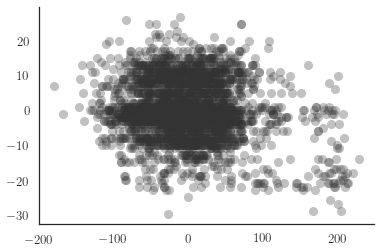

In [700]:
plt.plot(zscore(V), yz, **scatterkws)
print(linregress(zscore(V), yz))
sns.despine()

In [683]:
gendata['valhat'] = 6*logistic(V2) + 1
gendata['valhat'] = gendata['valhat'].map(int)
gendata['position'] = gendata['bp'] + gendata['wp']
gp = gendata.pivot_table(index='position', columns='zet', values='group', aggfunc=len, fill_value=0)
gvp = gendata.pivot_table(index='position', values='valhat')
gp['valhat'] = gvp.values
gp['valsum'] = gp[list(np.arange(1, 8, 1))].values.argmax(axis=1) + 1
gp.head()

zet,1,2,3,4,5,6,7,valhat,valsum
position,,,,,,,,,
000000000000000000000011000000010000000000000000110000000100000000000000,0,0,3,23,9,2,3,4.200,4
000000000000001000001010100000001000001010000000000000100101000000000000,0,1,11,17,8,0,3,1.375,4
000000000000001100000000100000001000000000000000010000000001000000110000,0,1,2,16,9,7,5,3.950,4
000000000000001100000010100000001000000000000000010000000101000000110000,0,1,3,21,7,1,7,1.575,4
000000000000001100000010100000001100000000100000010000000101000000110000,0,1,5,8,10,3,13,2.800,7


In [686]:
linregress(gp['valhat'], gp['valsum'])

LinregressResult(slope=0.028658154052210168, intercept=4.5855809612448635, rvalue=0.023294776870652626, pvalue=0.83957295740450255, stderr=0.14107985208224777)

# Old stuff (deprecated)

In [3]:
# num_filters = [4, 8, 16, 32, 64, 128]
# archnames = ["arch{}".format(n) for n in num_filters]
# columns = pd.MultiIndex.from_product([archnames, np.arange(5).astype(str)])
# tune_tidy = pd.DataFrame(index=df.index) #, columns=columns)
# tune_tidy['subject'] = df['subject']
# tune_tidy['group'] = df['group'] - 1

# pretrain_tidy = pd.DataFrame(index=df.index) #, columns=columns)
# pretrain_tidy['subject'] = df['subject']
# pretrain_tidy['group'] = df['group'] - 1


# subtune_tidy = pd.DataFrame(index=df.index) #, columns=columns)
# subtune_tidy['subject'] = df['subject']
# subtune_tidy['group'] = df['group'] - 1

In [ ]:
for nfil in num_filters:
    for prefit_idx in range(5):
        for test_split in range(5):
            # create network container with nfil filters architecture
            if nfil == 32:
                fname = '{} agg fit exp 1-4 {} tune fit exp 0.npz'.format(prefit_idx, test_split)
            else:
                fname = 'arch{} {} agg fit exp 1-4 {} tune fit exp 0.npz'.format(nfil, prefit_idx, test_split)
            
            arch = lambda input_var: archX(input_var, num_filters=nfil)
            net = Network(arch)
            net.load_params(os.path.join(paramsdir, fname))
            
            group_idx = (test_split-1)%5 # fuck this up if you want to see overfitting
            test_data = df.loc[df['group']==(group_idx+1)]
            Xt, yt, St, Gt, Npt = loading.unpack_data(test_data)
            res = net.itemized_test_fn(Xt, yt)
            l1 = 'arch{}'.format(nfil)
            l2 = str(prefit_idx)
            tune_tidy.loc[tune_tidy['group']==group_idx, (l1, l2)] = res

        if nfil == 32:
            fname = '{} split agg fit exp 1-4.npz'.format(prefit_idx)
        else:
            fname = 'arch{} {} split agg fit exp 1-4.npz'.format(nfil, prefit_idx)
            
        arch = lambda input_var: archX(input_var, num_filters=nfil)
        net = Network(arch)
        net.load_params(os.path.join(paramsdir, fname))
        Xt, yt, St, Gt, Npt = loading.unpack_data(df)
        res = net.itemized_test_fn(Xt, yt)
        l1 = 'arch{}'.format(nfil)
        l2 = str(prefit_idx)
        pretrain_tidy[(l1, l2)] = res

In [ ]:
def pivtidy(tidydf):
    t = tidydf[archnames].astype(float)
    t = t.mean(axis=1, level=0)
    t['subject'] = tidydf['subject']
    t['group'] = tidydf['group']
    tpiv = t.pivot_table(index='subject', values=archnames)
    return tpiv

pretrain_piv = pivtidy(pretrain_tidy)
tune_piv = pivtidy(tune_tidy)

print('pretrain agg\n')
for arc in archnames:
    print(arc, "\n", bmvs(pretrain_tidy[arc].values), "\n")

print('\npretrain sub\n')
for arc in archnames:
    print(arc, "\n", bmvs(pretrain_piv[arc].values), "\n")

print('\ntune agg\n')
for arc in archnames:
    print(arc, "\n", bmvs(tune_tidy[arc].values), "\n")

print('\ntune sub\n')
for arc in archnames:
    print(arc, "\n", bmvs(tune_piv[arc].values), "\n")

In [4]:
# ------ OLD -------
# arch = lambda input_var: multiconvX(input_var, subnet_specs=[(4, (1, 4)), (4, (4, 1)), (4, (4, 4))])
# num_filters = [4, 8, 16, 32, 64, 128]
# archnames = ["arch{}".format(n) for n in num_filters]
# columns = pd.MultiIndex.from_product([archnames, np.arange(5).astype(str)])
# tune_tidy = pd.DataFrame(index=df.index) #, columns=columns)
# tune_tidy['subject'] = df['subject']
# tune_tidy['group'] = df['group'] - 1

# pretrain_tidy = pd.DataFrame(index=df.index) #, columns=columns)
# pretrain_tidy['subject'] = df['subject']
# pretrain_tidy['group'] = df['group'] - 1


# subtune_tidy = pd.DataFrame(index=df.index) #, columns=columns)
# subtune_tidy['subject'] = df['subject']
# subtune_tidy['group'] = df['group'] - 1

archspecs = load_arch_specs(archname)
archs = dict()
archs[archname] = lambda input_var: multiconvX_ws(input_var, **archspecs['kwargs'])
arch = archs[archname]

net = Network(arch)


for prefit_idx in range(5):
    for test_split in range(5):
        
        # create network container with nfil filters architecture
        fname = '{} {} agg fit exp 1-4 {} tune fit exp 0.npz'.format(archname, prefit_idx, test_split)
        net.load_params(os.path.join(paramsdir, fname))

        group_idx = (test_split-1)%5 # fuck this up if you want to see overfitting
        test_data = df.loc[df['group']==(group_idx+1)]
        Xt, yt, St, Gt, Npt = loading.unpack_data(test_data)
        res = net.itemized_test_fn(Xt, yt)
        l1 = 'multiconvX'
        l2 = str(prefit_idx)
        tune_tidy.loc[tune_tidy['group']==group_idx, (l1, l2)] = res
        
        for subject in range(40):
            fname = '{} {} agg fit exp 1-4 {} subject {} tune fit exp 0.npz'.format(
                archname, prefit_idx, subject, test_split
            )
            net.load_params(os.path.join(paramsdir, fname))
            c = (subtune_tidy['group']==group_idx) & (subtune_tidy['subject']==subject)
            test_data = df.loc[(df['group']==(group_idx+1))&(df['subject']==subject)]
            Xt, yt, St, Gt, Npt = loading.unpack_data(test_data)
            subtune_tidy.loc[c, (l1, l2)] = net.itemized_test_fn(Xt, yt)

    fname = '{} {} split agg fit exp 1-4.npz'.format(archname, prefit_idx)
    net.load_params(os.path.join(paramsdir, fname))
    Xt, yt, St, Gt, Npt = loading.unpack_data(df)
    res = net.itemized_test_fn(Xt, yt)
    l1 = 'multiconvX'
    l2 = str(prefit_idx)
    pretrain_tidy[(l1, l2)] = res

In [11]:
pt = tune_tidy[['subject', 'group']].copy()
pt.columns = pt.columns.get_level_values(0)
pt['multiconvX'] = tune_tidy['multiconvX'].mean(axis=1)
ptpiv = pt.pivot_table(index='subject', values='multiconvX')

In [12]:
bmvs(ptpiv.values)

(Mean(statistic=1.9569956299072935, minmax=(1.8652257692999743, 2.0487654905146124)),
 Variance(statistic=0.12507991692401582, minmax=(0.08480425147075453, 0.18010844957876854)),
 Std_dev(statistic=0.35128509800731866, minmax=(0.29121169528498425, 0.42439185852083511)))

In [22]:
pt2 = tune_tidy[['subject', 'group']].copy()
pt2.columns = pt2.columns.get_level_values(0)
pt2[list(range(5))] = tune_tidy['multiconvX']
pt2piv = pt2.pivot_table(index='subject', values=list(range(5)))